In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
df = pd.read_csv('airline_passengers.csv',
                 index_col='Month',
                 parse_dates=True)


In [3]:
df['LogPassengers'] = np.log(df['Passengers'])

In [4]:
df.head()

,Passengers,LogPassengers,DiffLogPassengers
Month,,,
1949-01-01,112,4.718499,NaN
1949-02-01,118,4.770685,0.052186
1949-03-01,132,4.882802,0.112117
1949-04-01,129,4.859812,-0.022990
1949-05-01,121,4.795791,-0.064022


In [5]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [6]:
# Make supervised dataset
# Lets see if we can use T past values to predict the next value

series = df['LogPassengers'].to_numpy()

In [7]:
series[0:10]

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259])

In [8]:
series[10]

0.12629372532429262

In [9]:
series

array([ 0.05218575,  0.1121173 , -0.02298952, -0.06402186,  0.10948423,
        0.0919375 ,  0.        , -0.08455739, -0.13353139, -0.13473259,
        0.12629373, -0.0257525 ,  0.09134978,  0.11247798, -0.04348511,
       -0.07696104,  0.17563257,  0.13185213,  0.        , -0.0732034 ,
       -0.1722459 , -0.15415068,  0.20544397,  0.03509132,  0.03390155,
        0.17114826, -0.08803335,  0.05374428,  0.03428907,  0.11152127,
        0.        , -0.07836907, -0.12733942, -0.10398971,  0.12838117,
        0.02967577,  0.05129329,  0.06973334, -0.06419316,  0.01098912,
        0.17500891,  0.05358425,  0.05085842, -0.14660347, -0.09006082,
       -0.10477895,  0.12036368,  0.0102565 ,  0.        ,  0.18571715,
       -0.00424629, -0.02586351,  0.05933944,  0.08288766,  0.02985296,
       -0.13774193, -0.11620201, -0.15890128,  0.11034806,  0.01481509,
       -0.08167803,  0.22314355, -0.0346355 ,  0.0303711 ,  0.12062799,
        0.13447791, -0.03025441, -0.12334455, -0.12310606, -0.12

In [10]:
T = 10 # number of lags
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (133, 10) Y.shape (133,)


In [11]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [12]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.6837135048453121

In [13]:
lr.score(Xtest, Ytest)

0.6492870172668167

In [15]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T] = False

In [26]:
df.loc[train_idx, 'LR_lstep_train'] = lr.predict(Xtrain)
df.loc[test_idx, 'LR_lstep_test'] = lr.predict(Xtest)

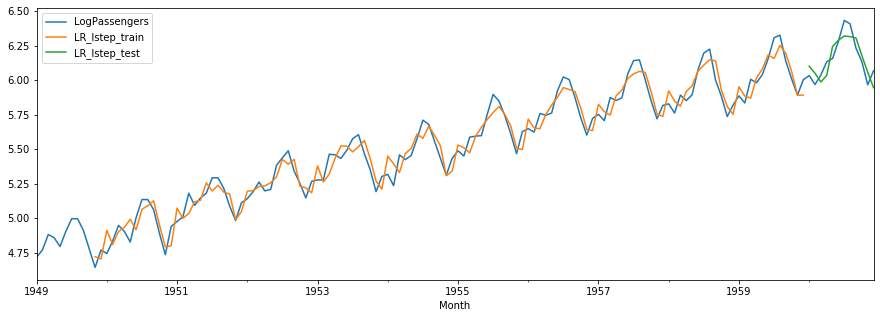

In [27]:
df[['LogPassengers',
    'LR_lstep_train',
    'LR_lstep_test']].plot(figsize=(15,5));

In [32]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
    p = lr.predict(last_x.reshape(1,-1))[0]

    # update the predictions list
    multistep_predictions.append(p)

    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p

In [33]:
# save multistep forecast to dataframe
df.loc[test_idx, 'LR_multistep'] = multistep_predictions

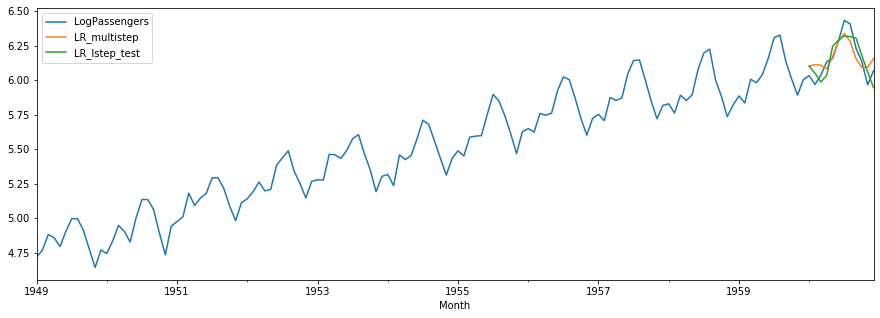

In [34]:
df[['LogPassengers',
    'LR_multistep',
    'LR_lstep_test']].plot(figsize=(15,5));

In [35]:
# make multi-output supervised dataset
Tx = T # number of step in the input
Ty = Ntest # number of steps in the output
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
    x = series[t:t+Tx]
    X.append(x)
    y = series[t+Tx:t+Tx+Ty]
    Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)


X.shape (123, 10) Y.shape (123, 12)


In [42]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [43]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.9734607773512528

In [44]:
# SST is zero!
lr.score(Xtest_m, Ytest_m)

/Users/maria/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:589: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  0.85


nan

In [47]:
r2_score(lr.predict(Xtest_m).flatten(),
         Ytest_m.flatten())


0.8018749676715227

In [48]:
df.loc[test_idx, 'LR_multioutput'] = \
lr.predict(Xtest_m).flatten()

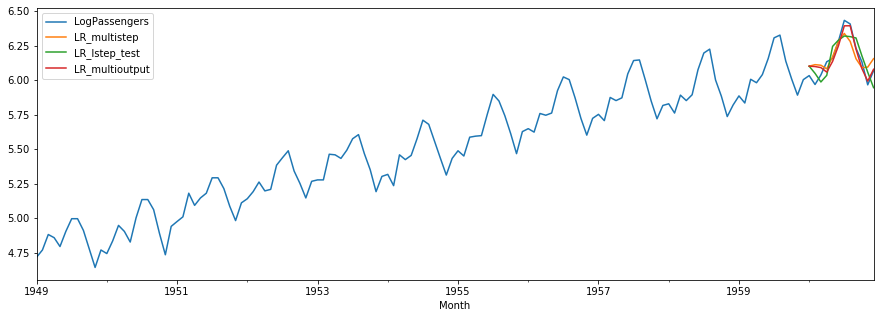

In [49]:
# plot all forecasts
cols = ['LogPassengers', 'LR_multistep',
        'LR_lstep_test', 'LR_multioutput']
df[cols].plot(figsize=(15,5));

In [57]:
def one_step_and_multistep_forecast(model, name):
    model.fit(Xtrain, Ytrain)
    print("One-step forecast:", name)

    # store l-step forecast
    df.loc[train_idx, f'{name}_lstep_train'] = model.predict(Xtrain)
    df.loc[test_idx, f'{name}_lstep_test'] = model.predict(Xtest)

    # generate multi-step forecast
    multistep_predictions = []

    # first test input
    last_x = Xtest[0]

    while len(multistep_predictions) < Ntest:
        p = model.predict(last_x.reshape(1,-1))[0]

        # update the predictions list
        multistep_predictions.append(p)

        # make the new input
        last_x = np.roll(last_x, -1)
        last_x[-1] = p

    # store multi-strp forecast
    df.loc[test_idx, f'{name}_multistep_test'] = multistep_predictions

    # MAPE of multi-step forecast
    mape = mean_absolute_percentage_error(Ytest, multistep_predictions)
    print("Test MAPE (multi-step):", mape)

    # plot 1-step and multi-step forecast
    cols = [
        'LogPassengers',
        f'{name}_lstep_train',
        f'{name}_lstep_test',
        f'{name}_multistep_test'
    ]
    df[cols].plot(figsize=(15,5));

In [61]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: SVR


NameError: name 'mean_absolute_percentage_error' is not defined